In [1]:
from PIL import Image
import cv2 
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [2]:
import glob, os

laser_samples = []
os.chdir("../res/laser_samples/")
for file in glob.glob("*"):
    laser_samples.append(file)

In [3]:
def disp_file(path):
    # In OpenCV, images are in BGR
    # In Pillow, images are in RGB 
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Converting BGR to RGB
    img = cv2.resize(img, (480, 360))
    display(Image.fromarray(img))

# Display cv2 image
def disp_img(cv_img):
    cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB) # Converting BGR to RGB
    cv_img = cv2.resize(cv_img, (480, 360))
    display(Image.fromarray(cv_img))


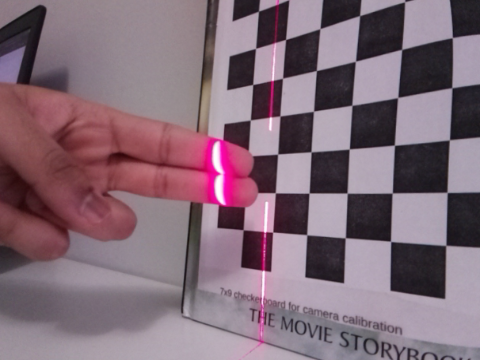

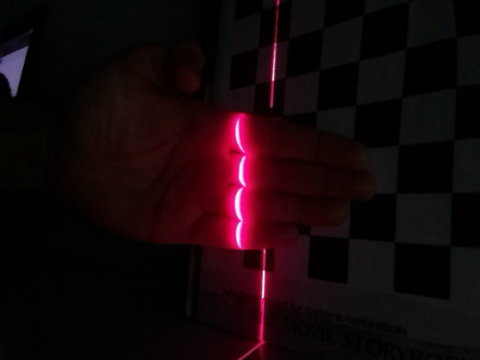

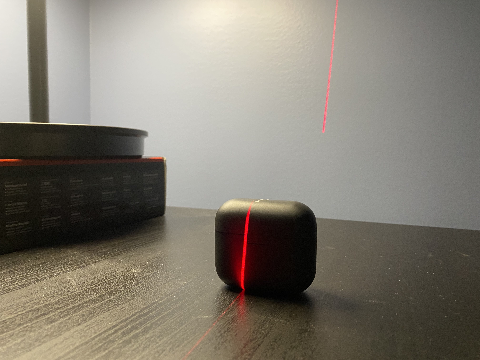

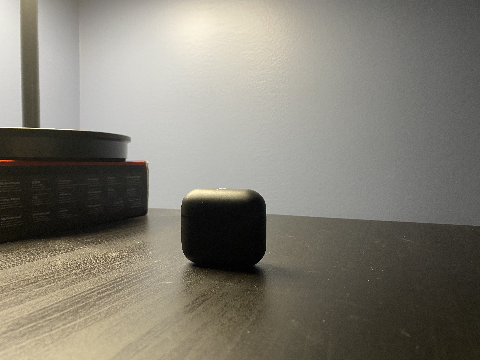

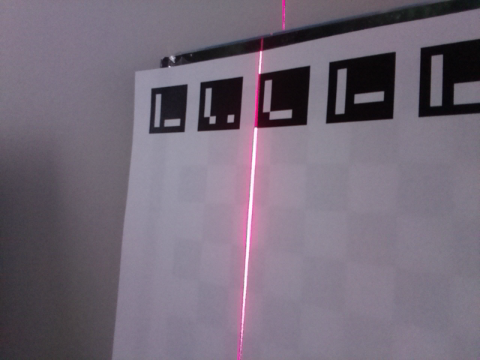

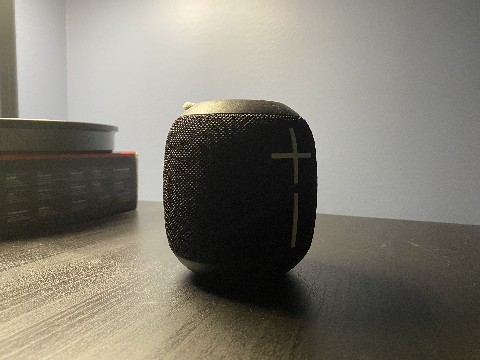

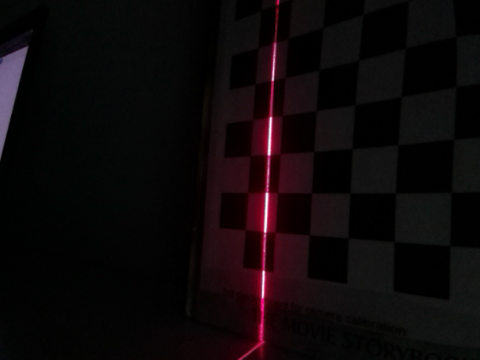

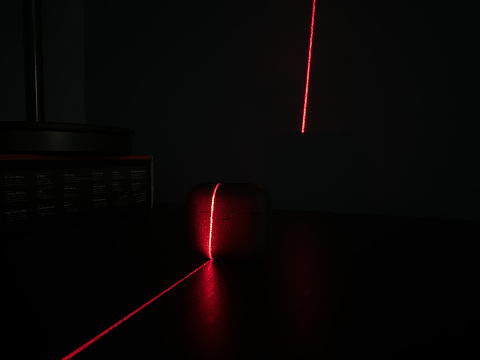

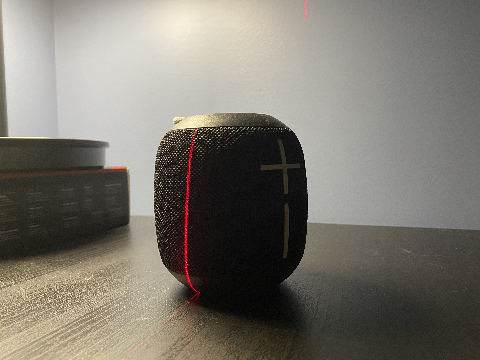

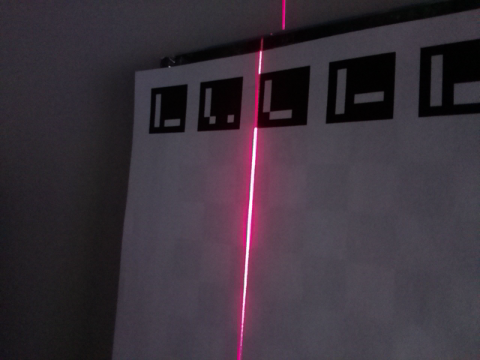

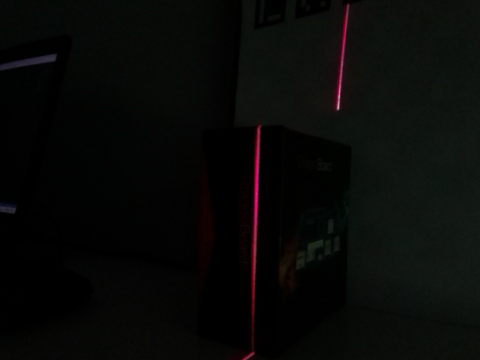

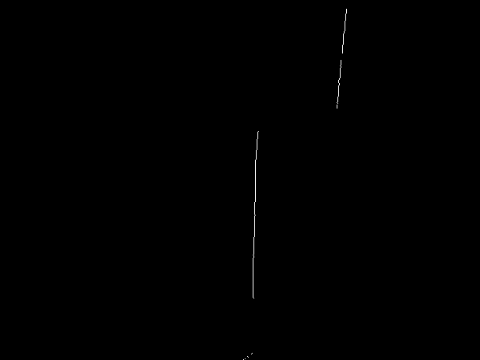

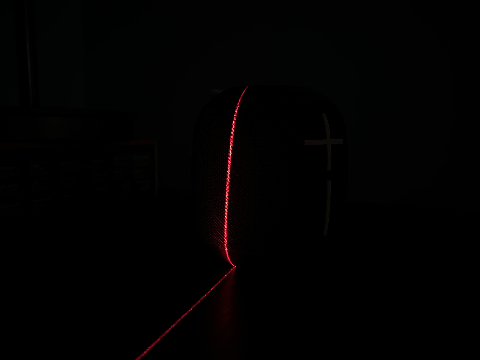

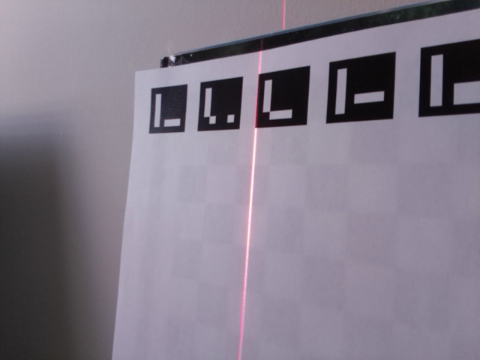

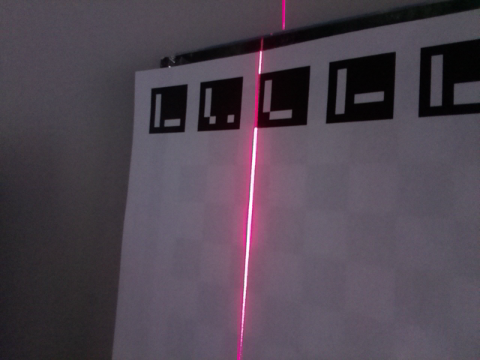

In [4]:
for file in laser_samples:
    disp_file(path=file)

## Idea 1. HSV Isolation
Manually tune the lower and upper bounds of HSV values to obtain laser line

In [5]:
import ipywidgets as widgets
from ipywidgets import interact, HBox

In [6]:
@interact
def hsv_isolation(lh=(0,255), ls=(0,255), lv=(0,255), uh=(0,255), us=(0,255), uv=(0,255)):
    img = cv2.imread(laser_samples[6])
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # define range of blue color in HSV
    lower_colour = np.array([lh, ls, lv])
    upper_colour = np.array([uh, us, uv])

    # Threshold the HSV image to get only blue colors
    mask = cv2.inRange(hsv, lower_colour, upper_colour)
    # inv = cv2.bitwise_not(mask)

    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(img,img, mask= mask)

    disp_img(res)

interactive(children=(IntSlider(value=127, description='lh', max=255), IntSlider(value=127, description='ls', …

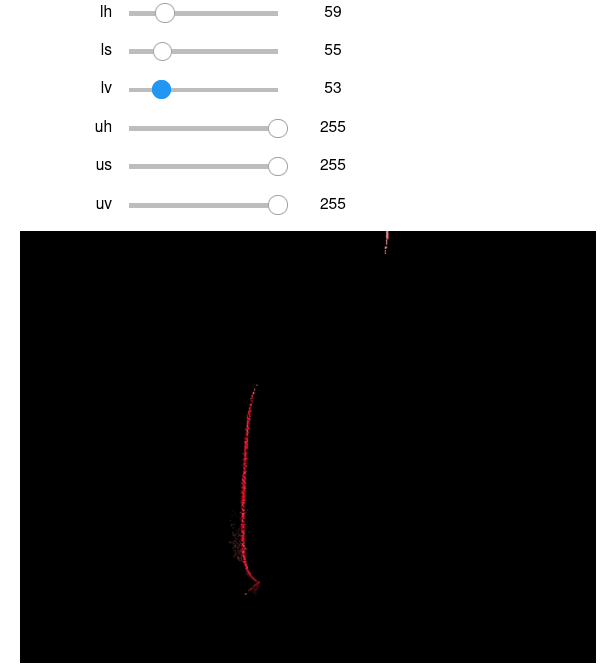

## Idea 2. Isolate Red Channel


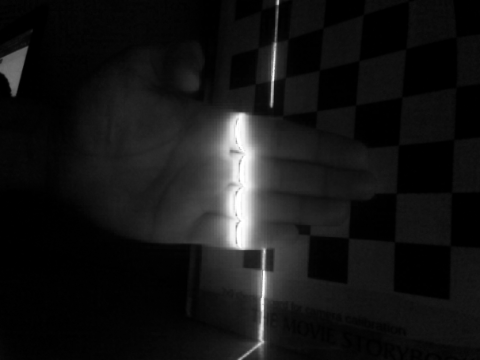

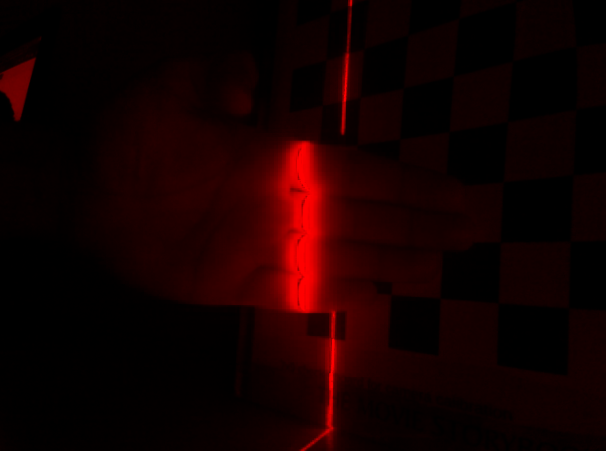

In [7]:
def show_red():
    img = cv2.imread(laser_samples[1])
    r = img[:, :, 2]  
    cv_img = cv2.resize(r, (480, 360))
    display(Image.fromarray(cv_img))

    # For displaying purposes, we turn off the blue and green channels, and then convert from BGR to RGB
    img[:,:,0] = 0
    img[:,:,1] = 0
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(img))
    
show_red()

## Idea 3. Edge Detection

This was not a good idea because it produced noise

In [8]:
@interact
def edge_detect(minval=(0,255), maxval=(0,255)):

    # Load image
    img = cv2.imread(laser_samples[0])
    
    # Read only the red channel (remember BGR corresponds to B=0, G=1, R=2)
    r = img[...,2]
    print(r.shape)
    ret,r = cv2.threshold(img,250,255,0)
    
    r_blur = cv2.GaussianBlur(r,(5,5),cv2.BORDER_DEFAULT)
    edges = cv2.Canny(r_blur, minval,maxval)       
    
    img[:,:,0] = 0
    img[:,:,1] = 0
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(edges))  

    

interactive(children=(IntSlider(value=127, description='minval', max=255), IntSlider(value=127, description='m…

In [9]:
# Might be useful avenue to check out for optimizations

# # https://stackoverflow.com/questions/7722519/fast-rgb-thresholding-in-python-possibly-some-smart-opencv-code
# @interact
# def red_threshold(r1 = (0,255), r2 = (0,255), g1 = (0,255), g2 = (0,255), b1 = (0,255), b2 = (0,255)):
#     arr = cv2.imread(laser_samples[0])

# #     arr = np.array(np.asarray(img))

#     R = [(r1,r2),(g1,g2),(b1,b2)]
#     red_range = np.logical_and(R[0][0] < arr[:,:,0], arr[:,:,0] < R[0][1])
#     green_range = np.logical_and(R[1][0] < arr[:,:,0], arr[:,:,0] < R[1][1])
#     blue_range = np.logical_and(R[2][0] < arr[:,:,0], arr[:,:,0] < R[2][1])
#     valid_range = np.logical_and(red_range, green_range, blue_range)

#     arr[valid_range] = 200
#     arr[np.logical_not(valid_range)] = 0
#     display(Image.fromarray(arr)) 
# #     outim = Image.fromarray(arr)
    
    

## Idea 4. Skeletionization

This was also very noisy and was abandoned

In [10]:
@interact
def skeletonize(thresh=(0,255)):
    # grab the grayscale image
    img = cv2.imread(laser_samples[0],0) 
    img = cv2.resize(img, (480, 360))
    size = np.size(img)
    skel = np.zeros(img.shape,np.uint8)
    
    # Convert to binary image
    ret,img = cv2.threshold(img,thresh,255,0)
    # cross shaped kernel
    element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    done = False

    while(not done):
        # Erosion: if any of the values in the kernel space have zero, the output pixel is 0
        #      Erosion removes tiny specks of noise and makes the area of interst thinner 
        # Dilation: if any of the values in the kernel space have one, then the output pixel is 1
        #      Dilation fills in holes 
        eroded = cv2.erode(img,element)
        temp = cv2.dilate(eroded,element)
        temp = cv2.subtract(img,temp)
        skel = cv2.bitwise_or(skel,temp)
        img = eroded.copy()
        
        zeros = size - cv2.countNonZero(img)
        if zeros==size:
            done = True
            
    display(Image.fromarray(skel))


interactive(children=(IntSlider(value=127, description='thresh', max=255), Output()), _dom_classes=('widget-in…

## Pipeline 1. GaussianBlur --> HSV Thresholding --> skeletonization
Note: Abandoned Method

In [11]:
@interact
def pipeline1(lh=(0,255), ls=(0,255), lv=(0,255), uh=(0,255), us=(0,255), uv=(0,255), thresh=(0,255)):
    img = cv2.imread(laser_samples[5])
    img = cv2.resize(img, (480, 360))
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv = cv2.GaussianBlur(hsv,(5,5),cv2.BORDER_DEFAULT)
    # define range of blue color in HSV
    lower_colour = np.array([lh, ls, lv])
    upper_colour = np.array([uh, us, uv])

    # Threshold the HSV image to get only blue colors
    mask = cv2.inRange(hsv, lower_colour, upper_colour)
    # inv = cv2.bitwise_not(mask)

    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(img,img, mask= mask)

    img = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)

    # grab the grayscale image
    size = np.size(img)
    skel = np.zeros(img.shape,np.uint8)

    # Convert to binary image
    ret,img = cv2.threshold(img,172,255,0)
    # cross shaped kernel
    element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    done = False

    while(not done):
        # Erosion: if any of the values in the kernel space have zero, the output pixel is 0
        #      Erosion removes tiny specks of noise and makes the area of interst thinner 
        # Dilation: if any of the values in the kernel space have one, then the output pixel is 1
        #      Dilation fills in holes 
        eroded = cv2.erode(img,element)
        temp = cv2.dilate(eroded,element)
        temp = cv2.subtract(img,temp)
        skel = cv2.bitwise_or(skel,temp)
        img = eroded.copy()

        zeros = size - cv2.countNonZero(img)
        if zeros==size:
            done = True
    

    display(Image.fromarray(skel))

interactive(children=(IntSlider(value=127, description='lh', max=255), IntSlider(value=127, description='ls', …

## Idea 5. Brightest Pixel Per Row

In [12]:
x = np.array([[3, 5, 1], [4, 1, 8], [9, 2, 1]], np.int32)

print(x)

max_loc = np.argmax(x, axis=1)
print(max_loc)

out = np.zeros((3,3))
print(out)

out[np.arange(len(max_loc)), max_loc] = 255

print(out)

[[3 5 1]
 [4 1 8]
 [9 2 1]]
[1 2 0]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[  0. 255.   0.]
 [  0.   0. 255.]
 [255.   0.   0.]]


In [13]:
@interact
def bppr(thresh=(0,255), lh=(0,255), ls=(0,255), lv=(0,255), uh=(0,255), us=(0,255), uv=(0,255)):
    img = cv2.imread(laser_samples[0])
    # Resize for illustration purposes
    img = cv2.resize(img, (720, 480))
    
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # define range of blue color in HSV
    lower_colour = np.array([lh, ls, lv])
    upper_colour = np.array([uh, us, uv])

    # Threshold the HSV image to get only get red colour
    mask = cv2.inRange(hsv, lower_colour, upper_colour)

    
    # Isolate the red channel
    img = img[...,2]
    
    ret,img = cv2.threshold(img,thresh,255,0)
    
    # For each row, get the position of the highest intensity
    bppr = np.argmax(img, axis=1)
    # Create emptry array of zeros of same size as img
    out = np.full_like(img, 0)
    # Set the highest intensity pixel locations to 255
    out[np.arange(len(bppr)), bppr] = 255
    
    
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(out,out, mask= mask)
    
    
    display(Image.fromarray(res)) 


interactive(children=(IntSlider(value=127, description='thresh', max=255), IntSlider(value=127, description='l…

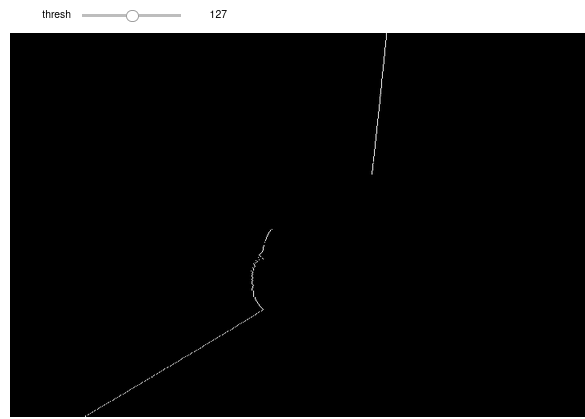

In [14]:
# WORKING WITH PRE-SET HSV THRESHOLDS
@interact
def bppr(thresh=(0,255)):
    img = cv2.imread(laser_samples[0])
    # Resize for illustration purposes
    img = cv2.resize(img, (720, 480))
    
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # define range of blue color in HSV
    lower_colour = np.array([146, 62, 0])
    upper_colour = np.array([255, 255, 255])

    # Threshold the HSV image to get only get red colour
    mask = cv2.inRange(hsv, lower_colour, upper_colour)

    
    # Isolate the red channel
    img = img[...,2]
    
    ret,img = cv2.threshold(img,thresh,255,0)
    
    # For each row, get the position of the highest intensity
    bppr = np.argmax(img, axis=1)
    # Create emptry array of zeros of same size as img
    out = np.full_like(img, 0)
    # Set the highest intensity pixel locations to 255
    out[np.arange(len(bppr)), bppr] = 255
    
    
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(out,out, mask= mask)
    
    
    display(Image.fromarray(res)) 

interactive(children=(IntSlider(value=127, description='thresh', max=255), Output()), _dom_classes=('widget-in…

## Pipeline 2. (Red Channel --> Thresholding --> BPPR) BITWISE_AND HSV Isolation

Best solution thus far

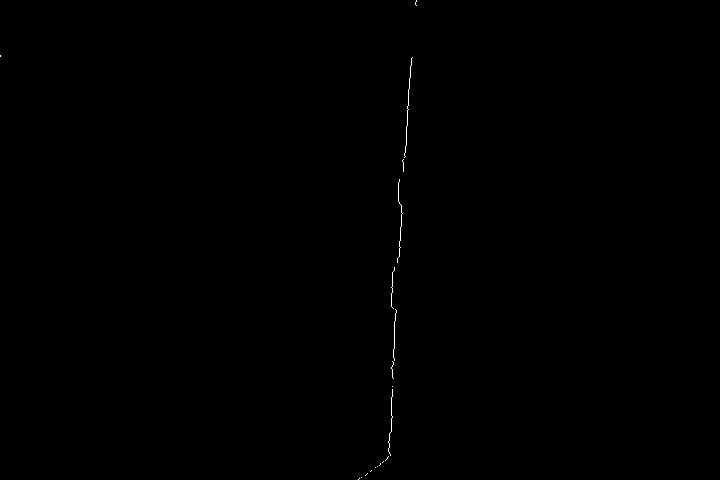

In [15]:
def pipeline3():
    img = cv2.imread(laser_samples[6])

    # Resize for illustration purposes
    img = cv2.resize(img, (720, 480))
    
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # define range of blue color in HSV
    lower_colour = np.array([146, 62, 0])
    upper_colour = np.array([255, 255, 255])

    # Threshold the HSV image to get only get red colour
    mask = cv2.inRange(hsv, lower_colour, upper_colour)

    
    # Isolate the red channel
    img = img[...,2]
    
    ret,img = cv2.threshold(img,144,255,0)
    
    # For each row, get the position of the highest intensity
    bppr = np.argmax(img, axis=1)
    # Create emptry array of zeros of same size as img
    out = np.full_like(img, 0)
    # Set the highest intensity pixel locations to 255
    out[np.arange(len(bppr)), bppr] = 255
    
    
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(out,out, mask= mask)

    display(Image.fromarray(res)) 
    
pipeline3()




# Sweep Test

In [16]:
os.getcwd()

'/home/abhi/Code/3D-Scanner/res/laser_samples'

In [17]:
os.chdir("../../res/pose_samples/charuco/tests/sweep")

In [18]:
import glob, os

charuco_samples = []

for file in sorted(glob.glob("*"), key=os.path.getmtime):
    if 'charuco_undist_' in file:
        charuco_samples.append(file)
        

In [19]:
charuco_samples

['charuco_undist_30.png',
 'charuco_undist_31.png',
 'charuco_undist_33.png',
 'charuco_undist_32.png',
 'charuco_undist_34.png',
 'charuco_undist_35.png',
 'charuco_undist_36.png',
 'charuco_undist_37.png',
 'charuco_undist_38.png',
 'charuco_undist_39.png',
 'charuco_undist_40.png',
 'charuco_undist_41.png',
 'charuco_undist_42.png',
 'charuco_undist_43.png']

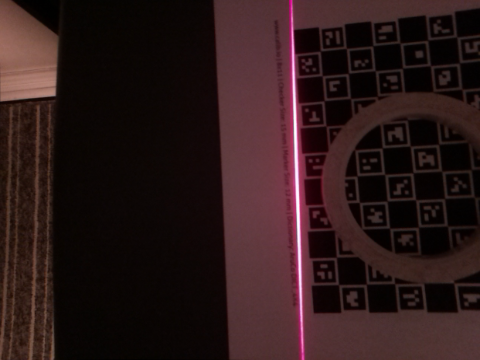

In [20]:
disp_file(charuco_samples[0])

In [21]:
import os
# os.chdir('../../../../../')
print(os.getcwd())

/home/abhi/Code/3D-Scanner/res/pose_samples/charuco/tests/sweep


In [22]:
# from scipy.ndimage import convolve, sobel

# def pipeline4(on, off):
#     img_on = cv2.imread(on)
#     img_off = cv2.imread(off)
    
#     # # Resize for illustration purposes
#     # img = cv2.resize(img, (720, 480))
    
#     img_on = img_on[:,:,2] - 0.5*(img_on[:,:,0] + img_on[:,:,1])
#     img_off = img_off[:,:,2] - 0.5*(img_off[:,:,0] + img_off[:,:,1])
    
#     img = img_on - img_off
    
#     # For each row, get the position of the highest intensity
#     # img = np.argmax(img, axis=1)    
    
#     # ver = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
#     # hor = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    
#     # ver_grad = convolve(img, ver)
#     # hor_grad = convolve(img, hor)
#     # grad = np.sqrt(np.square(ver_grad) + np.square(hor_grad))
    
#     # Create emptry array of zeros of same size as img
#     out = np.full_like(img, 0)
    
#     img = img.astype('int32')
    
#     dx = sobel(img, 0)
#     dy = sobel(img, 1)
#     mag = np.hypot(dx, dy)
    
#     bppr = np.argmax(mag, axis=1)
    
#     # Set the highest intensity pixel locations to 255
#     out[np.arange(len(bppr)), bppr] = 255
    
#     return out, bppr
    
    
# out, bppr = pipeline4('res/unit_tests/laser_iso/laser_on_0.png', 'res/unit_tests/laser_iso/laser_off_1.png')

In [23]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# import numpy as np
# from PIL import Image

In [24]:
# plt.figure(figsize = (20,20))
# plt.imshow(out, cmap='gray')


In [25]:
# import os
# print(os.getcwd())

In [26]:
# import math

# def pipeline5(file):
#     img = cv2.imread(file)
#     hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
#     # filtering red area of hue
#     redHueArea = 15
#     redRange = ((hsv[:, :, 0] + 360 + redHueArea) % 360) 
#     hsv[np.where((2 * redHueArea) > redRange)] = [0, 0, 0] 
    
#     # filtering by saturation
#     hsv[np.where(hsv[:, :, 1] < 95)] = [0, 0, 0]
    
#     # convert to rgb
#     rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    
#     # select only red grayscaled channel with low threshold  
#     gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
#     gray = cv2.threshold(gray, 15, 255, cv2.THRESH_BINARY)[1]
    
# #     # contours processing
# #     contours, hierarchy = cv2.findContours(gray.copy(), cv2.RETR_LIST, 1)
# #     for c in contours:
# #         area = cv2.contourArea(c)
# #         if area < 8: continue
# #         epsilon = 0.1 * cv2.arcLength(c, True) # tricky smoothing to a single line
# #         approx = cv2.approxPolyDP(c, epsilon, True)
# #         cv2.drawContours(img, [approx], -1, [0, 255, 255], -1)

#     contours, hierarchy = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
#     # biggest area
#     target = max(contours, key=lambda x: cv2.contourArea(x))
#     cv2.drawContours(img, [target], -1, [255, 0, 0], -1) # debug
# #     # just example of fitting
# #     x = target[:, :, 0].flatten()
# #     y = target[:, :, 1].flatten()
# #     poly = np.poly1d(np.polyfit(x, y, 5))
# #     for _x in range(min(x), max(x), 5): # too lazy for line/curve :)
# #         cv2.circle(img, (_x, int(poly(_x))), 3, [0, 255, 0])

#     return img
# #     cv2.imshow('result', img)
# #     cv2.waitKey(0)

In [27]:
# laser_samples2 = []
# # out = pipeline5('res/unit_tests/laser_iso/laser_on_0.png')
# for file in laser_samples:
#     print(file)
#     out = pipeline5('res/laser_samples/' + file)
#     laser_samples2.append(out)

In [28]:
# plt.figure(figsize = (20,20))
# plt.imshow(laser_samples2[4])

In [37]:
def extract_laser_bppr(frame): 
       
    # Isolate the red channel
    img = frame[...,2]
    
#     img = cv2.GaussianBlur(img,(3,3),0)
    img = cv2.medianBlur(img, 3)
#     ret,img = cv2.threshold(img,150,255,0)
#     _, img = cv2.threshold(img, 200, 255, 3)
    
    # Create emptry array of zeros of same size as img
    out = np.zeros_like(img)

    # For each row, get the position of the highest intensity
    bppr = np.argmax(img, axis=1)

    # Set the highest intensity pixel locations to 255
    out[np.arange(bppr.shape[0]), bppr] = 255
    
    return out, bppr

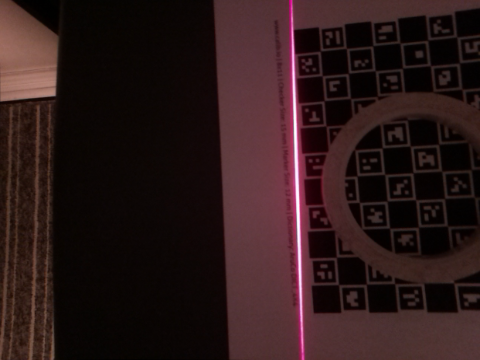

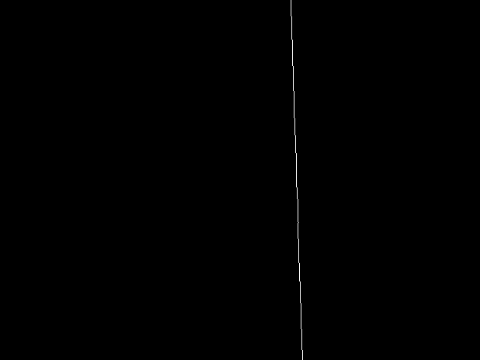

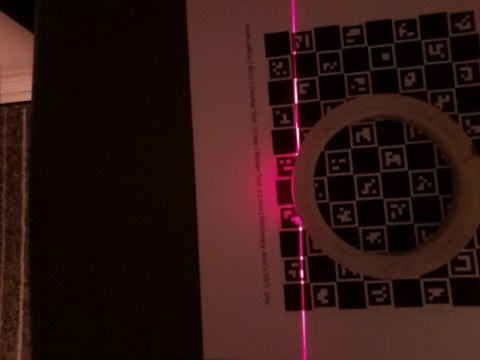

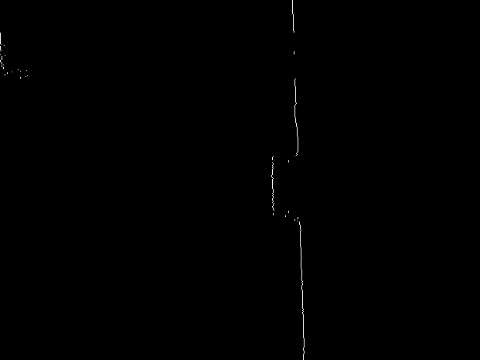

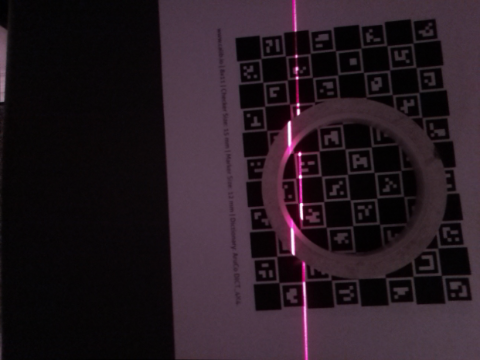

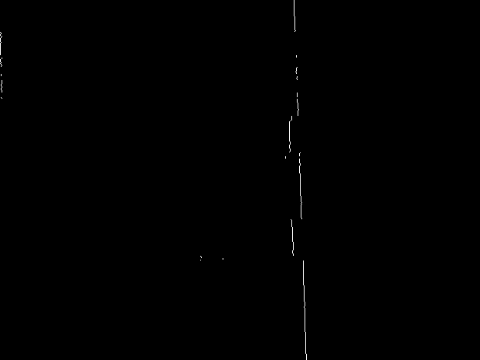

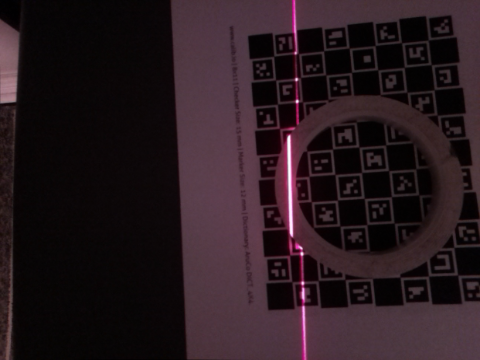

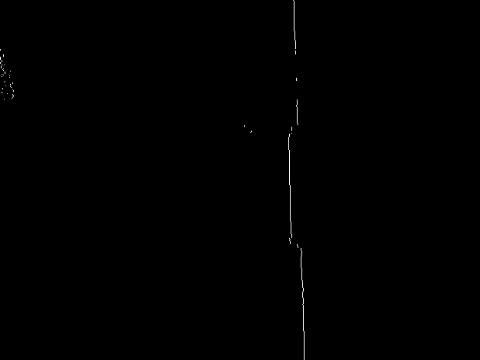

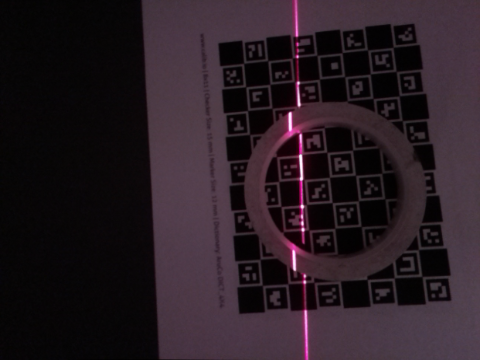

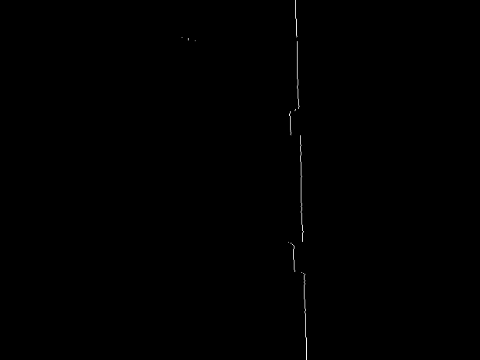

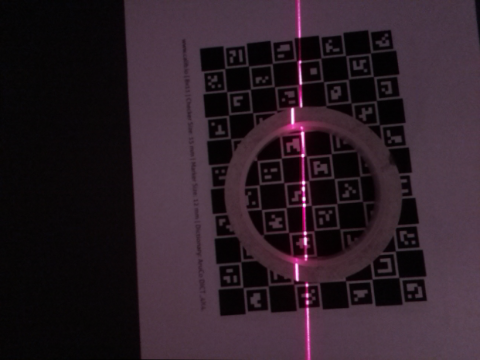

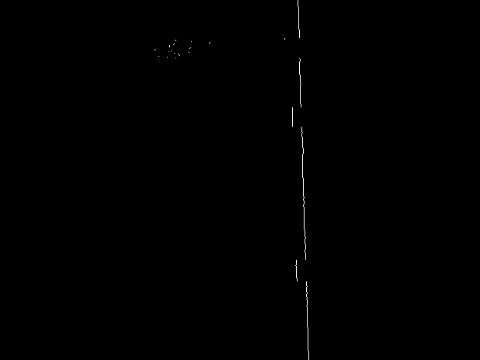

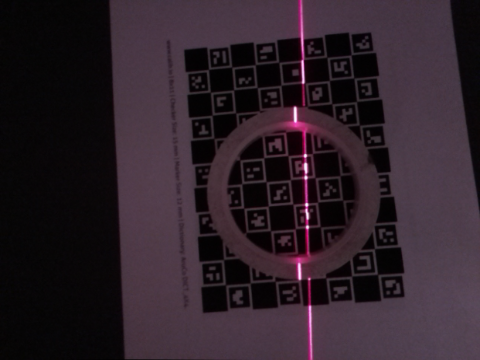

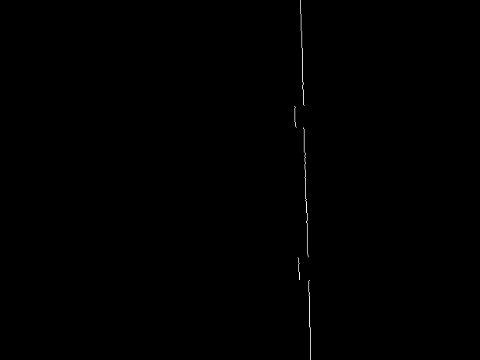

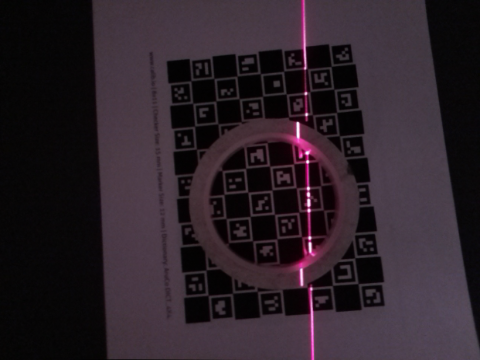

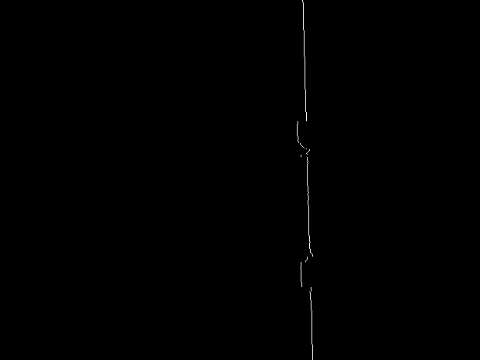

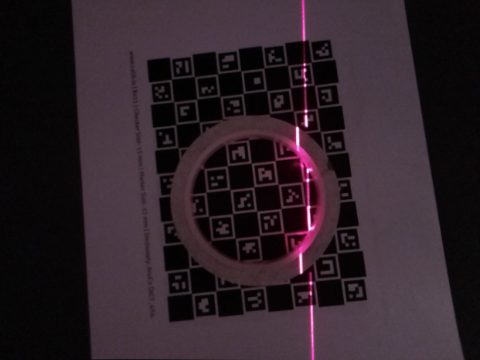

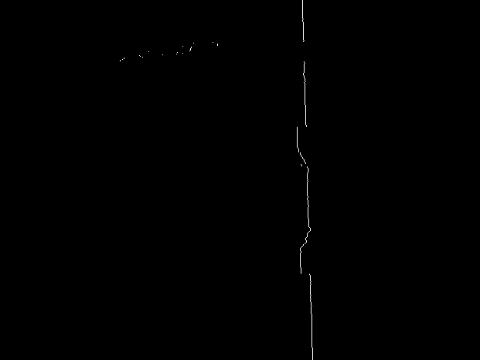

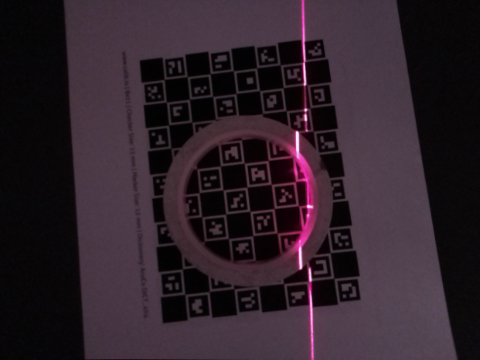

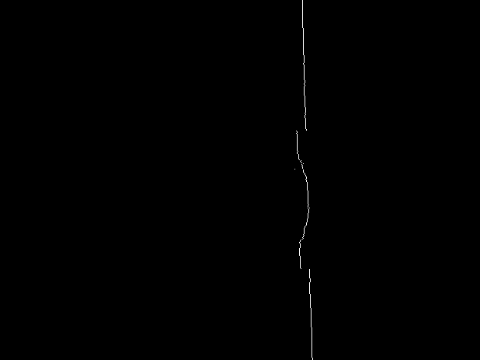

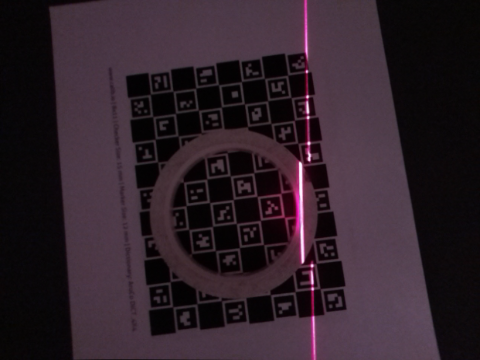

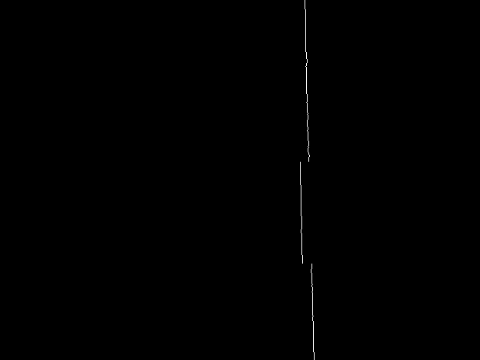

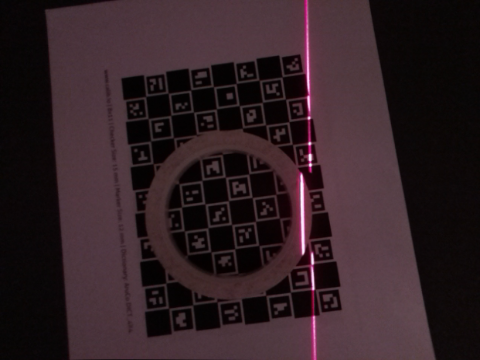

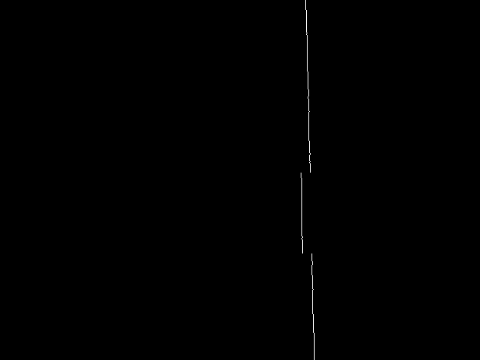

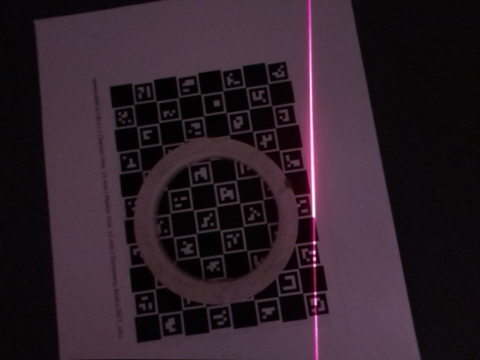

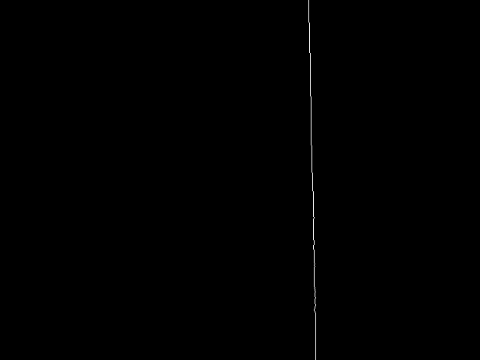

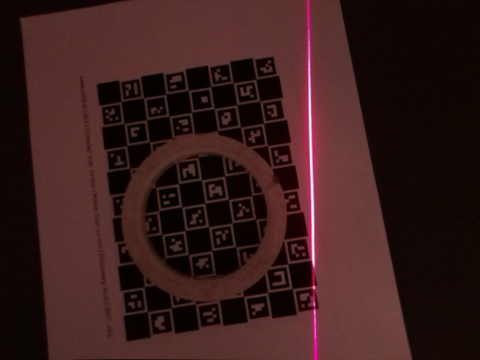

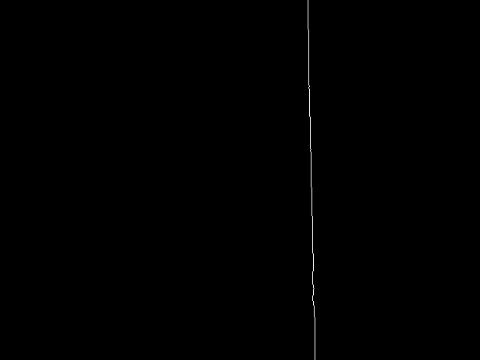

In [38]:
for img in charuco_samples:
    target = cv2.imread(img)
    res, bppr = extract_laser_bppr(target)
    disp_img(target)
    disp_img(res)